# NLP and the Web: Home Exercise 6

## Task 1: Inverted Index / Boolean Retrieval (5 Points)

__a)__ Next to many useful machine learning tools, __sklearn__ includes a collection of various datasets. In the ungraded practice notebook, you have already seen some examples on how to work with _20newsgroups_ which is a useful text corpus with numerous documents for a total of 20 different topics. For this notebook, we will use a selection of documents from the _20newsgroups_ dataset as our example corpus. Fetch all documents from _20newsgroups_ that adhere to the following parameters: 
- Include only documents of the 'test' subset and from the provided categories
- The documents should be shuffled with a random seed of 42
- Headers, footers and quotes should be removed  

To save some processing time in the following tasks, we want to further reduce our corpus. For this purpose, keep only the first 300 documents of the fetched result as your final corpus. Additionally, store the corresponding 300 target labels (categories) in a separate variable. 

In [1]:
categories = ['alt.atheism', 'rec.sport.hockey']

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='train',  categories=categories,
                                shuffle=True, random_state=42, remove=('headers', 'footers'))

newsgroup_data = newsgroups.data[0:300]

<br>__b)__ Implement a function _inverted_\__index_ that receives a list of documents and returns an inverted index. An inverted index is a key-value mapping where each key is a unique word from the vocabulary of a given corpus of documents. Each key maps to a postings list that contains the indices of all documents in which the key word occurs in at least once. The index should cover only lemmatized tokens that fully consist of alphabetic characters. For lemmas/keys that are not covered by the corpus vocabulary, the resulting index should return an empty list (_hint_: defaultdict).

Use your function to create an inverted index for the corpus from task 1a) and print the postings lists for the terms "skate", "faith" and "pizza".
Only use __spaCy__ for tokenization, lemmatization and detection of alphabetic tokens!

In [2]:
import en_core_web_sm
nlp = en_core_web_sm.load(disable=["tagger", "parser","ner"])

In [3]:
from spacy.lang.en import English
tokenizer = English().Defaults.create_tokenizer(nlp)
tokens = tokenizer(u'This is a sentence')
print()

In [4]:
from spacy.lang.en.stop_words import STOP_WORDS

def lemmatize(text):
    """Perform lemmatization and non-alphabetic removal in the clean text
       Returns a list of lemmas of unique value
    """
    doc = nlp(text)
    lemma_list = list(set([str(tok.lemma_).lower() for tok in doc if tok.is_alpha]))
    return lemma_list

In [5]:
test = "I simply can understand how this can work"
print(list(set(lemmatize(test))))

['understand', 'how', 'can', 'simply', 'this', 'i', 'work']


In [6]:
from spacy.vocab import Vocab
from collections import defaultdict

def inverted_index(docs):
    """
    Creates an inverted index for a given corpus of documents.
    @param docs: array-like object containing documents 
    @return: inverted index 
    """
    postings = defaultdict(list) 
    for i, doc in enumerate(docs):
        lemmas = lemmatize(doc)
        for lemma in lemmas: 
            # Add new lemma if not exists
            if lemma not in postings:
                postings[lemma] = [i]
            else: 
                postings[lemma].append(i)
                postings[lemma] = list(sorted(set(postings[lemma])))
    
    return postings

In [7]:
# create inverted index from the choosen newsgroup
inverted_index = inverted_index(newsgroup_data)

test_list = ["skate", "faith","pizza"]
for tok in test_list:
    print(inverted_index[tok])

[27, 34, 67, 70, 82, 89, 103, 171, 251, 265, 276]
[41, 105, 127, 159, 183, 245]
[105]


<br>__c)__ Implement the optimized intersection function _intersect([t1, ..., tn])_ for multiple AND queries from the lecture (slide 52). Try to keep the implementation as close as possible to the given pseudocode. 

_Hint:_ Use the inverted index from the previous exercise to access the postings in lines 2 and 5 of the pseudocode. The function _intersect_\__(postings1, postings2)_ that is used in line 5 of the pseudocode is already implemented for you. 

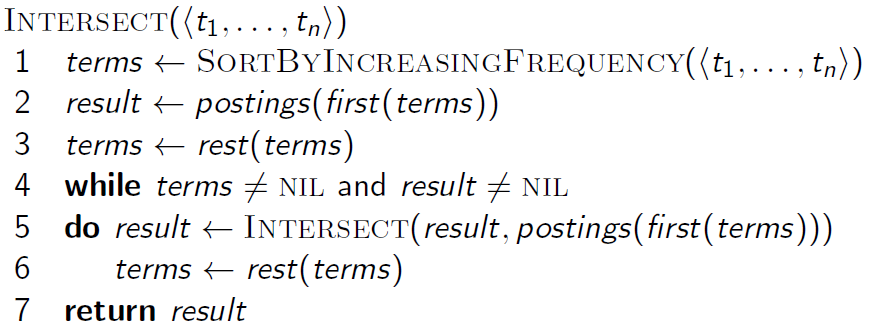

In [8]:
from collections import Counter

def intersect(terms):
    """
    Intersects the postings lists for multiple query terms as shown in the above pseudocode. 
    @param terms: array-like object containing terms, e.g. ['good', 'pizza', 'darmstadt']  
    @return: array-like object containing indices of documents in which all query terms occur 
    """
    terms_sorted = sort_by_increasing_frequency(terms)

    result = inverted_index[terms_sorted[0]]
    
    for i in range(1,len(terms_sorted)):
        result = intersect_(result, inverted_index[terms_sorted[i]])
    return result  

def sort_by_increasing_frequency(terms):
    """
    Sorts terms by the length of their postings lists. Used in line 1 of the pseudocode.  
    @param terms: array-like object containing terms
    return: array-like object containing terms, ordered increasingly by their document frequency
    """
    terms_freq = {}
    for term in terms:
        posting = inverted_index[term]
        terms_freq[term] = len(posting)
    sorted_list = sorted(terms_freq.items(), key=lambda t: t[1])
    return [k for (k,v) in sorted_list]

def intersect_(postings1, postings2):
    """
    Intersects two (sub)lists containing postings. Used in line 5 of the pseudocode.  
    @param postings1: array-like object containing postings list of a term
    @param postings2: array-like object containing postings list of a term
    return: array-like object containing intersection of postings1 and postings2
    """
    return list(set(postings1) & set(postings2))

In [9]:
print(sort_by_increasing_frequency(test_list))
#print([sorted_list[0] for item in sorted_list])

['pizza', 'faith', 'skate']


<br>__d)__ Finally, create a function _boolean_\__retrieval_ that takes a list of terms and interprets them as an AND query (e.g., the input ["best", "pizza", "pie"] should be interpreted as "best AND pizza AND pie"). The return value of the function should be a list of all document indices that contain all of the query tokens. Apply the function for the following queries and print the number of retrieved documents for each query:  
- best AND goals
- best AND goals AND overtime
- religions 
- most AND common AND religions

In [10]:
def boolean_retrieval(query):
    """
    Performs Boolean retrieval for a given query to determine all relevant documents.
    @param query: array-like object containing query terms, e.g. ["my", "query"]
    return: any object containing document indices that fulfill the conjunction of all query terms
    """
    return intersect(query)

In [11]:
queries =  [["best", "goals"],["best", "goals","overtime"],["religions"],["most", "common","religions"]]
for q in queries: 
    print(boolean_retrieval(q))

[]
[]
[]
[]


## Task 2: tf-idf (4 Points)

A fundamental technique in the context of language processing is the transformation of documents into vector representations.  In the previous exercises, you have already used a CountVectorizer to turn documents into a "bag of words". Another popular method that you have seen in this week's lecture as well as in the ungraded tutorial notebook is tf-idf weighting. Hereby, the term frequency (tf) of a specific word is put into relation with its inversed document frequency (idf), with the intention to reflect how important the word is to a document in a corpus.

In this task, you will create the functionality to calculate tf-idf weights from scratch, turn the documents of our examplary corpus into tf-idf vector representations and use them to apply a simple text classification. As long as not stated otherwise, please do not use any other tools or libraries other than __math__, __numpy__ and __spaCy__.

In [12]:
# useful imports for this task
import math
import numpy as np

<br>__a)__ Implement a function _tf_\__weight(term, doc)_. For a given term and a document, the function should return the term frequency weight that is calculated with the following formula: 

&emsp;&emsp;&emsp;&emsp; $\text{tf-weight}_{\text{term,doc}} = 1 + \log_{10}(\text{tf}_{\text{term,doc}})$ &emsp;&emsp; $\text{if tf}_{\text{t,d}} > 0\text{, else }  0$

Implement a second function _idf_\__weights(docs)_ that receives the corpus of documents and returns the idf weights for all words from the corpus vocabulary. Similar to task 1b), this vocabulary shall cover only the lemmas of alphabetic words (_hint:_ your inverted index function from the previous task can be very useful here). The idf weight for one term can be calculated like this: 

&emsp;&emsp;&emsp;&emsp; $\text{idf-weight}_{\text{term}} = \log_{10}(\frac{\text{#docs}}{\text{df}_{\text{term}}})$

In [13]:
def tf_weight(term, doc):
    """
    Calculates term frequency weighting for a given term and document. 
    @param term: term string 
    @param doc: document string
    return: tf weight for the given term and document 
    """
    # count of term in d
    t = len([tok.text.lower() for tok in nlp(doc) if tok.text.lower() == term])
    
    # count of word in d
    d = len([tok.text.lower() for tok in nlp(doc) if tok.is_alpha])
    
    if t > 0:
        log = 1+np.log10(t/d)
    else: 
        log = 0
        
    return log

from collections import Counter
def idf_weights(docs):
    """
    Calculates inverse document frequency weighting for a corpus of documents. 
    @param docs: array-like object containing documents
    return: array-like object containing idf scores for all lemmas of the corpus vocabulary
    """
    lemmas = []
    for doc in docs: 
        lemmas =  lemmas + [str(tok.lemma_).lower() for tok in nlp(doc) if tok.is_alpha]
    
    term_occ = Counter(lemmas)
    
    for k, v in term_occ.items():
        term_occ[k] = np.log10(len(docs)/v)
        
    return term_occ

<br>__b)__  Implement a function _tf_\__idf_\__vectors(docs)_ that transforms each document of a given corpus into a tf-idf vector representation. Each vector should be |V|-dimensional (where again V is the corpus vocabulary consisting of all alphabetic word lemmata). In other words, each vector entry represents one word from the corpus vocabulary; for each term in a document, the corresponding entry in the document's vector should be the tf-idf weight. If a term does not occur in a document at all, the corresponding vector entry should be 0.

Use the function to determine the tf-idf vector representations of all documents in our exemplary corpus from task 1a).   

In [14]:
import time 

def tf_idf_vectors(docs): 
    """
    Calculates tf-idf-vectors for the given documents. 
    @param docs: array-like object containing documents
    return: array-like object containing tf-idf-vectors for each document"""
    start = time.time()
    
    idf = idf_weights(docs)
    term_idx = {}
    for i,term in enumerate(idf.keys()):
        term_idx[term]=i
    
    tf_idf_vecs = []
    
    for i,doc in enumerate(docs):
        print('process doc ',str(i))
        doc_lemmas= lemmatize(doc)
        doc_vec = np.zeros((len(idf.keys())),dtype=np.float32)
        for lemma in idf.keys():
            if lemma in doc_lemmas: 
                idx= term_idx[lemma]
                doc_vec[idx] = idf[lemma]*tf_weight(lemma,doc)
        tf_idf_vecs.append(doc_vec)
    
    elapsed = (time.time() - start)
    print("Process time: ", elapsed)
    
    return tf_idf_vecs

__c)__ Now we want to use our tf-idf functionality in a machine learning context. First, split your set of vectors from the previous task into a train and a test set. Use the first 80% of the vectors for the train set and the remaining vectors as the test set. Do not shuffle the data when creating the splits. Afterwards, train a NaiveBayes Classifier on the train set and use it to predict the test set. Determine the accuracy of the classifier's predictions.

Use GaussianNB from sklearn for NaiveBayes classification. Additionally, you can use any functions from sklearn.model_selection and sklearn.metrics.

In [15]:
X = tf_idf_vectors(newsgroup_data)

process doc  0
process doc  1
process doc  2
process doc  3
process doc  4
process doc  5
process doc  6
process doc  7
process doc  8
process doc  9
process doc  10
process doc  11
process doc  12
process doc  13
process doc  14
process doc  15
process doc  16
process doc  17
process doc  18
process doc  19
process doc  20
process doc  21
process doc  22
process doc  23
process doc  24
process doc  25
process doc  26
process doc  27
process doc  28
process doc  29
process doc  30
process doc  31
process doc  32
process doc  33
process doc  34
process doc  35
process doc  36
process doc  37
process doc  38
process doc  39
process doc  40
process doc  41
process doc  42
process doc  43
process doc  44
process doc  45
process doc  46
process doc  47
process doc  48
process doc  49
process doc  50
process doc  51
process doc  52
process doc  53
process doc  54
process doc  55
process doc  56
process doc  57
process doc  58
process doc  59
process doc  60
process doc  61
process doc  62
pr

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

#X = tf_idf_vectors(docs)
print("finished creating tf.idf vectors")
y = newsgroups.target[0:300]
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
clf = GaussianNB()
clf.fit(X_train,y_train)
print("finished training")
y_hat= clf.predict(X_test)
acc= accuracy_score(y_test,y_hat)

finished creating tf.idf vectors
finished training


In [17]:
print(acc)

0.8833333333333333


## Task 3: Questions (1 Point)

Please discuss the following questions briefly (max. 3 sentences per question): 
1. What is the intention behind using the logarithm for the calculation of term frequency (tf)?
2. Why does inverse document frequency (idf) have little/no effect on queries with one term? 
3. What is the "feast or famine" problem that can occur for Boolean retrieval like in Task 1? How can ranked retrieval overcome this issue? 

__Answer:__ 
1. We add log normalization to dampen the importance of term that has a high frequency. If document A contains 10 word "CCC" and document B contains 100 words "CCC" then the document B is more relevant for the word "CCC" than document B. But if document A contains 1 million words "CCC" and document B contains 2 millions words "CCC" then whether it is document A or B isn't important anymore. 
2. The IDF value in the case of 1-term-query is a constant for all documents.
3. Boolean queries often result in either too few (=0) "famine" or too many "feast". With ranking, large result sets are not an issue. Just show the top 10 results and the user won’t be overwhelmed